In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

2025-01-28 04:03:05.599630: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 04:03:05.603147: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 04:03:05.640719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 04:03:05.640756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 04:03:05.640794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from qkeras import *
from qkeras.utils import model_quantize
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import plotting

## Section 1: Load the Dataset and pre-trained model

### 1.1 Load train and test dataset

In [3]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

### 1.2 Load the pre-trained model
The model is trained with jet-tagging open datase: `hls4ml_lhc_jets_hlf`.

We used 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

Look at the **training notebook** to see the details: [01_keras_training.ipynb](https://github.com/nrp-nautilus/6nrp-hls4ml/blob/main/01_keras_training.ipynb)

In [4]:
model = load_model('model_1/KERAS_check_best_model.h5')

#### Check model accuracy

In [5]:
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.7579759036144579


## Section 2: Convert the model to FPGA firmware with `hls4ml`

Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml. First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. Then we will synthesize the model with Vitis HLS and check the metrics of latency and FPGA resource usage.

### 2.1 Make an hls4ml config & model
The `hls4ml` Neural Network inference library is controlled through a configuration dictionary. In this example we'll use the most simple variation, you can look at the [`hls4ml` official tutorials](https://fastmachinelearning.org/hls4ml-tutorial/README.html) for more advanced models and configuration.

In [6]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj', part='XCU250-FIGD2104-2L-E'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  S

#### Let's visualise what we created. The model architecture is shown, annotated with the shape and data types


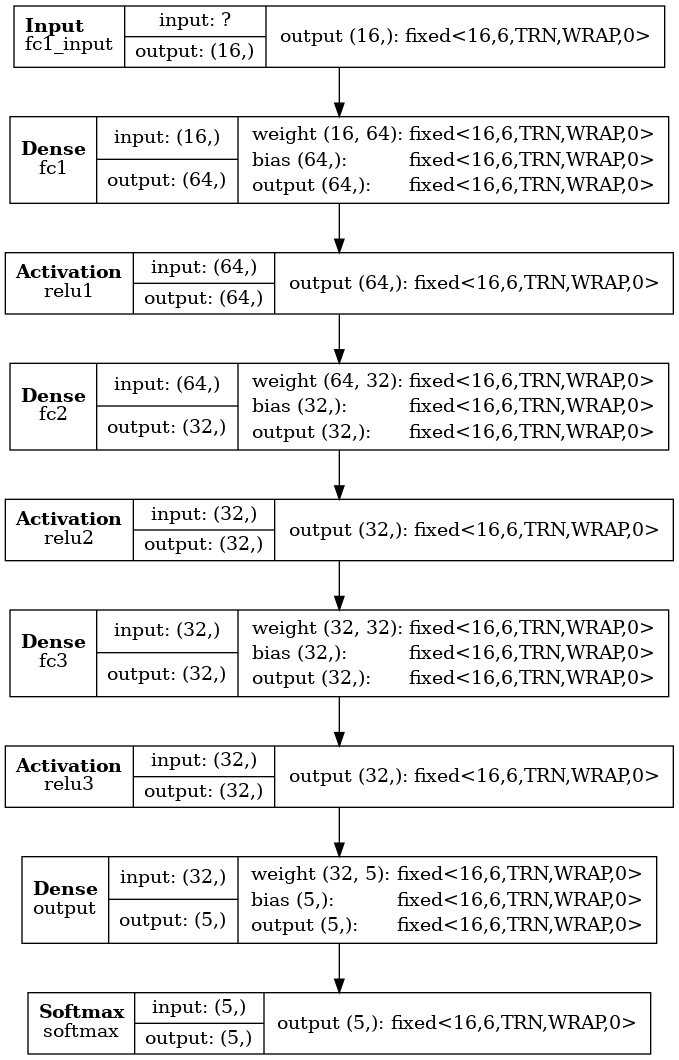

In [7]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)


### 2.2 Compile the HLS model and predict

In [8]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


### 2.3 Compare the Results

Keras  Accuracy: 0.7579759036144579
hls4ml Accuracy: 0.7584397590361446


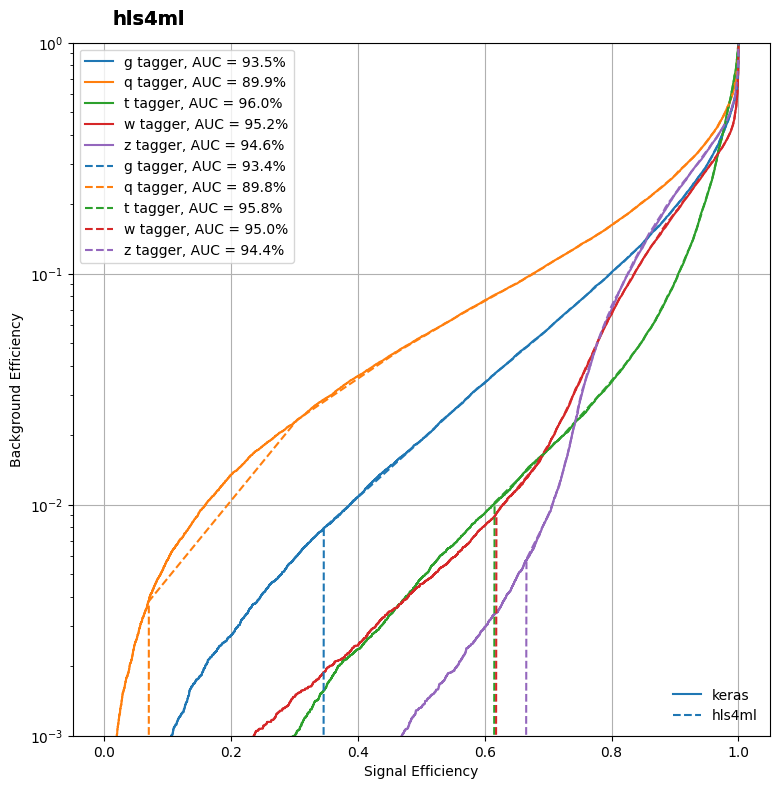

In [9]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Section 3: Synthesize

Now we'll actually use Vitis HLS to synthesize the model. We can run the build using a method of our hls_model object. After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board. In this case, we'll just review the reports that Vitis HLS generates, checking the latency and resource usage.

This can take several minutes.

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vitis_hls.log`

In [10]:
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2022.2/bin/:' + os.environ['PATH']

In [11]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'xilinx' on host 'jupyter-ekhoda-40ucsd-2eedu' (Linux_x86_64 version 5.15.0-122-generic) on Tue Jan 28 04:03:33 UTC 2025
INFO: [HLS 200-10] On os Ubuntu 20.04.4 LTS
INFO: [HLS 200-10] In directory '/home/xilinx/6nrp-hls4ml/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/home/xilinx/6nrp-hls4ml/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-1510] Running: set_top myproject 
INFO: [HLS 200-1510] Running: add_files firmware/myproject.cpp -cflags -std=c++0x 
INFO

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '3.636',
  'BestLatency': '15',
  'WorstLatency': '15',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '8',
  'DSP': '2557',
  'FF': '24233',
  'LUT': '116694',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

### 3.1 Check the reports

Print out the reports generated by Vitis HLS. Pay attention to the Latency and the 'Utilization Estimates' sections


In [12]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')


Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue Jan 28 04:09:09 2025

* Version:        2022.2 (Build 3670227 on Oct 13 2022)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.636 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------+